# Oscillation SNR

...

### Issue

Many measures of interest are implicitly dependent on the signal strength, or, effectively, the relative power, of the oscillations under study. This can also be though of as the signal-to-noise ratio of the data under study. If the power of the oscillation is low, then measures may be 'noisy', exhibiting high variability due a difficulty in resolving measurements.

### Solution

For analyses of interest, consider the required signal-to-noise ratio to get good measurements. Several strategies may be useful to optimize signal strength, including thing like using individualized frequency ranges to more specifically detect oscillations, and applying burst detection to any analyze data with rhythms present. In some cases, an amplitude threshold may be useful to select data of a high-enough magnitude for subsequent analyses. 

### Related Work

- [A robust statistical framework for instantaneous electroencephalogram phase and frequency estimation and analysis](https://doi.org/10.1088/1361-6579/aa93a1), Sameni & Seraj, 2017

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from fooof.utils import trim_spectrum
from fooof.plts.spectra import plot_spectrum_shading, plot_spectra_shading

from neurodsp.sim import sim_combined, sim_oscillation, sim_powerlaw
from neurodsp.filt import filter_signal
from neurodsp.spectral import compute_spectrum
from neurodsp.timefrequency import amp_by_time, freq_by_time, phase_by_time
from neurodsp.utils import create_times, remove_nans, set_random_seed
from neurodsp.plts.time_series import plot_time_series, plot_instantaneous_measure

## Functions

In [2]:
def phase_locking_value(theta1, theta2):
    """Compute the phase locking value between two signals.
    From: https://dsp.stackexchange.com/questions/25165/phase-locking-value-phase-synchronization
    """
    
    complex_phase_diff = np.exp(np.complex(0, 1) * (theta1 - theta2))
    plv = np.abs(np.sum(complex_phase_diff)) / len(theta1)
    
    return plv

## Settings

In [3]:
import seaborn as sns
sns.set_context('poster')

In [4]:
# Set random seed
set_random_seed(808)

In [5]:
# Set functions to use for averaging and variance
avg_func = np.nanmedian
var_func = np.nanvar

In [6]:
# Define general simulation settings
n_seconds = 25
fs = 1000
times = create_times(n_seconds, fs)

In [7]:
# Define parameters for the simulations
cf = 10
exp = -1.5
ap_filt = (3, 100)

In [8]:
# Collect parameters and set up simulations
components = {'sim_powerlaw' : {'exponent' : exp, 'f_range' : ap_filt},
              'sim_oscillation' : {'freq' : cf}}

# Define relative power of the signal components
comp_vars1 = [1, 1.0]
comp_vars2 = [1, 0.1]

In [9]:
# Define frequency ranges of interest
alpha_range = (8, 12)
psd_range = (4, 35)

In [10]:
plt_kwargs = {'xlim' : [2.75, 4.5], 'xlabel' : '', 'ylabel': ''}

# old xlim: [1.5, 4.5]

In [11]:
alpha_color = '#1882d9'

In [12]:
color_cyc = plt.rcParams['axes.prop_cycle'].by_key()['color']

## Simulate Time Series

For this, we will simulate signals with oscillations of different relative powers. 

Note that the simulated data vary on relative power, but that the oscillations within each signal are themselves static and consistent. 

This means that any measured variability within the simulations necessarily stems from measurement issues.

In [13]:
# Create the oscillation componenents
osc1 = sim_oscillation(n_seconds, fs, cf, variance=1)
osc2 = sim_oscillation(n_seconds, fs, cf, variance=0.1)

# Create the aperiodic component
ap = sim_powerlaw(n_seconds, fs, exp, f_range=ap_filt)

In [14]:
# Combine the signals
sig1 = ap + osc1
sig2 = ap + osc2

In [15]:
# Simulate time series
#sig1 = sim_combined(n_seconds, fs, components, comp_vars1)
#sig2 = sim_combined(n_seconds, fs, components, comp_vars2)

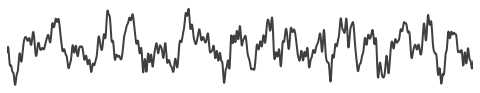

In [16]:
# Plot the time series of the first signal - high power
_, ax = plt.subplots(figsize=(8, 2.5))
plot_time_series(times, sig1, lw=2, alpha=0.75,
                 xlim=plt_kwargs['xlim'], ylim=[-3.5, 3.5], ax=ax)
plt.axis('off')
plt.savefig('figures/07-ts-highpow.pdf', bbox_inches='tight')

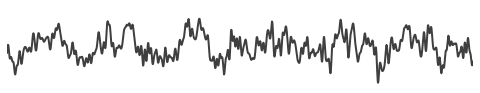

In [17]:
# Plot the time series of the first signal - low power
_, ax = plt.subplots(figsize=(8, 2.5))
plot_time_series(times, sig2, lw=2, alpha=0.75, 
                 xlim=plt_kwargs['xlim'], ylim=[-3.5, 3.5], ax=ax)
plt.axis('off')
plt.savefig('figures/07-ts-lowpow.pdf', bbox_inches='tight')

## Compute Power Spectra

Next we can compute and compare the power spectra of each respective signal. 

This will allow us to visualize and check the relative power within each signal. 

In [18]:
nperseg = 1.5 * fs

In [19]:
# Compute the power spectra of each of the example signals
freqs1, powers1 = trim_spectrum(*compute_spectrum(sig1, fs, nperseg=nperseg), psd_range)
freqs2, powers2 = trim_spectrum(*compute_spectrum(sig2, fs, nperseg=nperseg), psd_range)

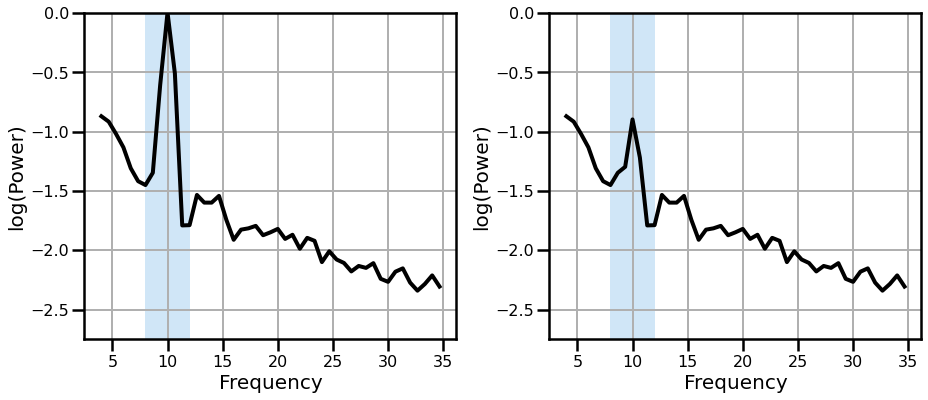

In [20]:
# Plot the power spectra of the two signal
_, axes = plt.subplots(1, 2, figsize=(15, 6))
plot_spectrum_shading(freqs1, powers1, alpha_range, log_powers=True,
                      color='black', lw=4, shade_colors=alpha_color, ax=axes[0])
axes[0].set_ylim(-2.75, -0.)
plot_spectrum_shading(freqs2, powers2, alpha_range, log_powers=True,
                      color='black', lw=4, shade_colors=alpha_color, ax=axes[1])
axes[1].set_ylim(-2.75, -0.)
plt.subplots_adjust(wspace=0.25)

In [21]:
# Save out PSD plots

_, ax = plt.subplots(figsize=(7, 6))
plot_spectrum_shading(freqs1, powers1, alpha_range, log_powers=True,
                      color='black', lw=4, shade_colors=alpha_color, ax=ax)
axes[0].set_ylim(-2.75, -0.)
plt.savefig('figures/07-psd-highpow.pdf', bbox_inches='tight')
plt.close()

_, ax = plt.subplots(figsize=(7, 6))
plot_spectrum_shading(freqs2, powers2, alpha_range, log_powers=True,
                      color='black', lw=4, shade_colors=alpha_color, ax=ax)
axes[1].set_ylim(-2.75, -0.)
plt.subplots_adjust(wspace=0.25)
plt.savefig('figures/07-psd-lowpow.pdf', bbox_inches='tight')
plt.close()

## Compute Instantaneous Measures

Next, let's compute some instantaneous measures of interest on our signals. 

For these examples, we have added an alpha oscillations, so we will examine instantaneous measures of the alpha range. 

In [22]:
# Filter each signal, to the alpha range
sig_filt1 = filter_signal(sig1, fs, 'bandpass', alpha_range)
sig_filt2 = filter_signal(sig2, fs, 'bandpass', alpha_range)

In [23]:
# Compute instantaneous measures, for each signal
pha1 = phase_by_time(sig_filt1, fs)
amp1 = amp_by_time(sig_filt1, fs)
fre1 = freq_by_time(sig_filt1, fs)

pha2 = phase_by_time(sig_filt2, fs)
amp2 = amp_by_time(sig_filt2, fs)
fre2 = freq_by_time(sig_filt2, fs)

## Plot Instantaneous Measures

We can now plot our measures of interest, separately for the high and low power signals, and compare them. 

Recall that there is no temporal variability in the simulated oscillations. 

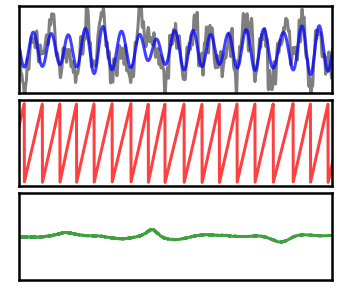

In [24]:
# Plot instantaneous measures for the firt signal (high power)
_, axes = plt.subplots(3, 1, figsize=(6, 5))
plot_time_series(times, [sig1, sig_filt1], ax=axes[0], ylim=[-3, 3],
                 alpha=[0.5, 0.75], colors=['k', 'b'], **plt_kwargs)
plot_instantaneous_measure(times, pha1, 'phase', ax=axes[1],
                           alpha=[0.75], colors='r', **plt_kwargs)
#plot_instantaneous_measure(times, [sig_filt1, amp1], 'amplitude', ax=axes[2],
#                           alpha=[0.75, 0.75], colors=['b', 'r'], ylim=[-1.75, 1.75], **plt_kwargs)
plot_instantaneous_measure(times, fre1, 'frequency',  ax=axes[2],
                           alpha=[0.75], colors='g', ylim=[0, 20], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.075)
plt.savefig('figures/07-measures-highpow.pdf', bbox_inches='tight')

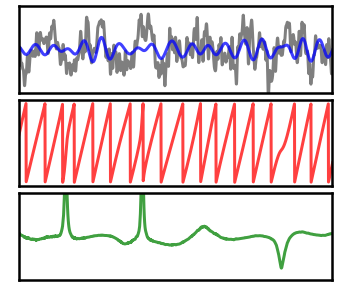

In [25]:
# Plot instantaneous measures for the second signal (low power)
_, axes = plt.subplots(3, 1, figsize=(6, 5))
plot_time_series(times, [sig2, sig_filt2], ax=axes[0], ylim=[-3, 3],
                 colors=['k', 'b'], alpha=[0.5, 0.75], **plt_kwargs)
plot_instantaneous_measure(times, pha2, 'phase', ax=axes[1],
                           alpha=0.75, colors=['r'], **plt_kwargs)
#plot_instantaneous_measure(times, [sig_filt2, amp2], 'amplitude', ax=axes[2],
#                           ylim=[-1.75, 1.75], alpha=[0.75, 0.75], colors=['b', 'r'], **plt_kwargs)
plot_instantaneous_measure(times, fre2, 'frequency', ax=axes[2],
                           alpha=0.75, colors='g', ylim=[0, 20], **plt_kwargs)
for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.075)
plt.savefig('figures/07-measures-lowpow.pdf', bbox_inches='tight')

As we can see in the above plots and comparisons, there is much great measured variability in the low power signal. 

This variability does not accurately reflect the underlying signal, but rather is a limitation of the low power. 

## Compare Measures

In the above, we visually compared our measures. 

Next lets more quantitatively compare them, by computing descriptive statistics on the computed measures. 

In [26]:
# Set a buffer to ignore on the edges of the signal, for these comparisons
#   This is just a way to exclude any potential edge artifacts, from the filtering
buff = 1*fs

In [27]:
# Compute descriptive statistics of the first signal (high power)
print('Pha - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(pha1[buff:-buff]), var_func(pha1[buff:-buff])))
print('Amp - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(amp1[buff:-buff]), var_func(amp1[buff:-buff])))
print('Fre - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(fre1[buff:-buff]), var_func(fre1[buff:-buff])))

Pha - mean: -0.0015, var: 3.2903
Amp - mean: +1.4258, var: 0.1501
Fre - mean: +9.9995, var: 0.2774


In [28]:
# Compute descriptive statistics of the first signal (low power)
print('Pha - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(pha2[buff:-buff]), var_func(pha2[buff:-buff])))
print('Amp - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(amp2[buff:-buff]), var_func(amp2[buff:-buff])))
print('Fre - mean: {:+1.4f}, var: {:1.4f}'.format(\
    avg_func(fre2[buff:-buff]), var_func(fre2[buff:-buff])))

Pha - mean: -0.0090, var: 3.3023
Amp - mean: +0.5912, var: 0.0868
Fre - mean: +9.8158, var: 4.6507


In the above measures, we see increased variability of the measures, in particular for frequency, and also for amplitude.

Note that the above comparison does not really make sense for phase, a circular variable. 

Therefore, we can compare that one a little differently. For a consistent oscillation, the unwrapped phase should show consistent variation, which can be calculated as the differences between measured (unwrapped) phase values. 

For a better measure of phase, let's compare the unwrapped phases. 

In [29]:
# Compute unwrapped phase diffs for the first signal (high power)
pha1_uw = np.unwrap(remove_nans(pha1[buff:-buff])[0])
pha1_diffs = np.diff(pha1_uw)

# Compute unwrapped phase diffs for the first signal (low power)
pha2_uw = np.unwrap(remove_nans(pha2[buff:-buff])[0])
pha2_diffs = np.diff(pha2_uw)

In [30]:
# Compute descriptive statistics of the first signal (low power)
print('Pha (sig1) - mean: {:+1.4f}, var: {:1.5f}'.format(\
    avg_func(pha1_diffs[buff:-buff]), var_func(pha1_diffs[buff:-buff])))
print('Pha (sig2) - mean: {:+1.4f}, var: {:1.5f}'.format(\
    avg_func(pha2_diffs[buff:-buff]), var_func(pha2_diffs[buff:-buff])))

Pha (sig1) - mean: +0.0629, var: 0.00001
Pha (sig2) - mean: +0.0618, var: 0.00017


An additional phase measure we can check is phase monotonicity. 

The unwrapped phase of ongoing oscillations should be monotonically increasing. 

However, in some cases, we can see 'phase slips', or a negative deflection of the measured (unwrapped) phase. 

The phase monotonicity for the measured signals is another measure of variable, whereby (for this case) higher values are more accurate. 

In [31]:
# Comptute and compare the measured phase monotonicity of the signals
print('Phase monotonicity (sig 1):  {:1.4f}'.format(\
    sum(pha1_diffs >= 0) / len(pha1_diffs)))
print('Phase monotonicity (sig 2):  {:1.4f}'.format(\
    sum(pha2_diffs >= 0) / len(pha2_diffs)))

Phase monotonicity (sig 1):  1.0000
Phase monotonicity (sig 2):  0.9987


In [32]:
pows = []
filts = []
phas = []

osc_powers = [0.01, 0.05, 0.1, 0.15, 0.25, 0.5]

for osc_pow in osc_powers:
    osc = sim_oscillation(n_seconds, fs, cf, variance=osc_pow)
    sig = ap + osc
    
    freqs, powers = trim_spectrum(*compute_spectrum(sig, fs, nperseg=nperseg), psd_range)
    pows.append(powers)
    
    filt = filter_signal(sig, fs, 'bandpass', alpha_range, remove_edges=False)
    filts.append(filt)
    
    phas.append(phase_by_time(filt, fs))

In [87]:
cmap = [plt.cm.viridis(ind) for ind in np.linspace(0., 1, len(osc_powers)+1)]
#cmap = [plt.cm.cividis(ind) for ind in np.linspace(0., 1, len(osc_powers)+1)]
#cmap = [plt.cm.Oranges(ind) for ind in np.linspace(0., 1, len(osc_powers)+1)]
#cmap = [plt.cm.magma(ind) for ind in np.linspace(0., 1, len(osc_powers)+1)]

cmap = [plt.cm.Purples(ind) for ind in np.linspace(0.5, 0.9, len(osc_powers)+1)]

In [88]:
inds = [0, 2, 5]
tcols = [cmap[ind+1] for ind in inds]
#tcols = ['purple', 'orange', 'brown']

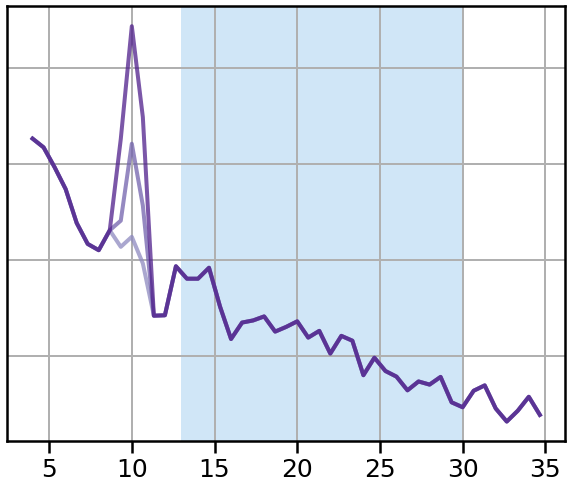

In [89]:
plot_spectra_shading(freqs, [pows[ind] for ind in inds], 
                     alpha_range, alpha_color, lw=4,
                     alpha=0.75, log_powers=True)

ax = plt.gca()

for line, color in zip(ax.get_lines(), tcols):
    line.set_color(color)
    #line.set_alpha(0.8)

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(25)
    
ax.set_xlabel(''); ax.set_ylabel('');
for xlabel_i in ax.get_yticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
    
for tic in ax.yaxis.get_major_ticks():
    tic.tick1line.set_visible(False)

plt.savefig('figures/07-spectra_snrs.pdf', bbox_inches='tight')

In [36]:
plt_clear = {'xlabel': '', 'ylabel': ''}

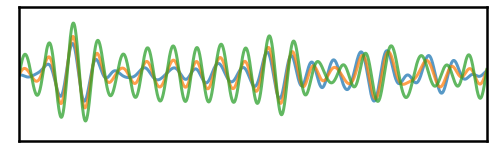

In [37]:
_, ax = plt.subplots(figsize=(8, 3))
plot_time_series(times, [filts[ind] for ind in inds],
                 xlim=[7.6, 9.5], alpha=0.75,
                 **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
plt.savefig('figures/07-filters_snrs.pdf', bbox_inches='tight')

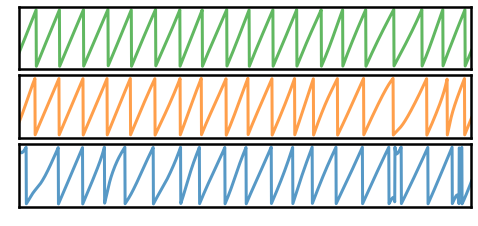

In [38]:
# Plot instantaneous measures for the second signal (low power)
_, axes = plt.subplots(3, 1, figsize=(8, 4))

plot_instantaneous_measure(times, phas[inds[0]], 'phase', ax=axes[2],
                           xlim=[7.6, 9.5], alpha=0.75, **plt_clear, 
                           colors=[color_cyc[0]])

plot_instantaneous_measure(times, phas[inds[1]], 'phase', ax=axes[1],
                           xlim=[7.6, 9.5], alpha=0.75, **plt_clear, 
                           colors=[color_cyc[1]])

plot_instantaneous_measure(times, phas[inds[2]], 'phase', ax=axes[0],
                           xlim=[7.6, 9.5], alpha=0.75, **plt_clear, 
                           colors=[color_cyc[2]])


for ax in axes: ax.set_xticks([]); ax.set_yticks([]);
plt.subplots_adjust(hspace=0.1)
plt.savefig('figures/07-phases_snrs.pdf', bbox_inches='tight')

In [39]:
v1 = 1.0
v2 = 0.1

In [40]:
plt_kwargs

{'xlim': [2.75, 4.5], 'xlabel': '', 'ylabel': ''}

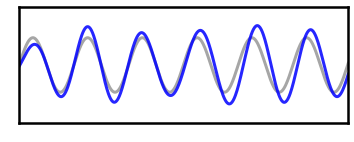

In [41]:
# Plot instantaneous measures for the firt signal (high power)
_, ax = plt.subplots(figsize=(6, 2.75))
plot_time_series(times, [osc1, sig_filt1], ax=ax, 
                 xlim=[2, 2.6], ylim=[-3, 3],
                 xlabel='', ylabel='',
                 alpha=[0.35, 0.85], colors=['k', 'b'])
plt.xticks([]); plt.yticks([]);
plt.savefig('figures/07-tsfilt_high.pdf', bbox_inches='tight')

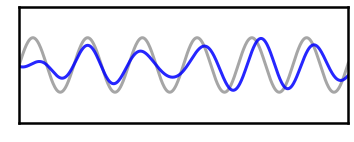

In [42]:
# Plot instantaneous measures for the firt signal (high power)
_, ax = plt.subplots(figsize=(6, 2.75))
plot_time_series(times, [osc1, sig_filt2], ax=ax, 
                 xlabel='', ylabel='',
                 xlim=[2, 2.6], ylim=[-3, 3],
                 alpha=[0.35, 0.85], colors=['k', 'b'])
plt.xticks([]); plt.yticks([]);
plt.savefig('figures/07-tsfilt_low.pdf', bbox_inches='tight')

In [43]:
osc1

array([-2.70006240e-18,  8.87992043e-02,  1.77247959e-01, ...,
       -2.64997196e-01, -1.77247959e-01, -8.87992043e-02])

In [44]:
phs1 = []
phs2 = []

for ind in range(10):
    ap = sim_powerlaw(n_seconds, fs, exp, ap_filt)
    
    t1 = osc1 + ap
    t2 = osc2 + ap
    
    
    phs1.append(phase_by_time(t1, fs, alpha_range))
    phs2.append(phase_by_time(t2, fs, alpha_range))

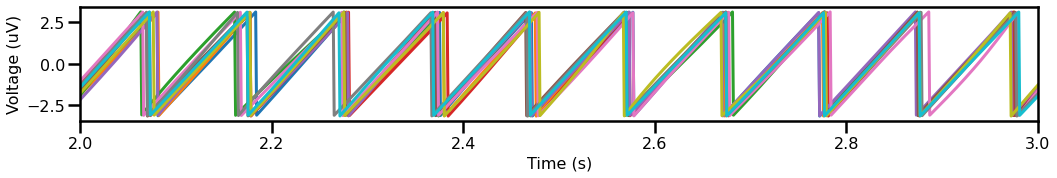

In [45]:
plot_time_series(times, phs1, xlim=[2, 3])

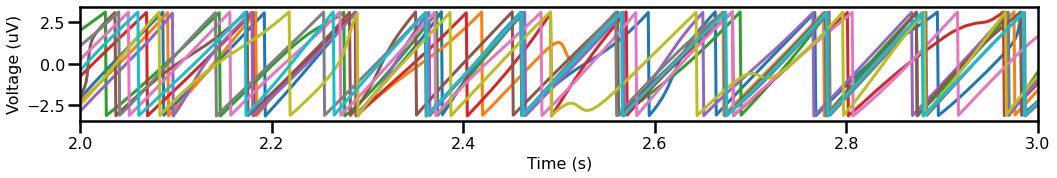

In [46]:
plot_time_series(times, phs2, xlim=[2, 3])

In [47]:
true_phase = phase_by_time(osc1, fs)

In [48]:
phs1 = np.array(phs1)
phs2 = np.array(phs2)

In [49]:
shd1 = np.nanstd(phs1, 0)
shd2 = np.nanstd(phs2, 0)

/Users/tom/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


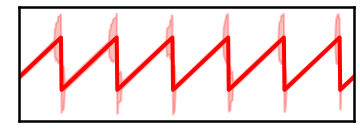

In [50]:
_, ax = plt.subplots(figsize=(6, 2.75))
plot_instantaneous_measure(times, true_phase, xlim=[2, 2.6],
                           xlabel='', ylabel='',
                           colors='red', lw=4, ax=ax)
plt.xticks([]); plt.yticks([]);
plt.fill_between(times, true_phase-shd1, true_phase+shd1, color='red', alpha=0.25)
plt.savefig('figures/07-pha_low.pdf', bbox_inches='tight')

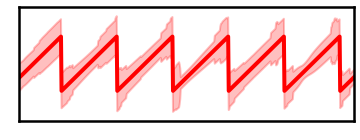

In [51]:
_, ax = plt.subplots(figsize=(6, 2.75))
plot_instantaneous_measure(times, true_phase, xlim=[2, 2.6], 
                           xlabel='', ylabel='',
                           colors='red', lw=4, ax=ax)
plt.xticks([]); plt.yticks([]);
plt.fill_between(times, true_phase-shd2, true_phase+shd2, color='red', alpha=0.25)
plt.savefig('figures/07-pha_high.pdf', bbox_inches='tight')

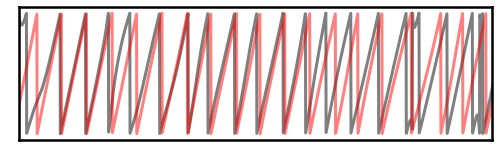

In [52]:
_, ax = plt.subplots(figsize=(8, 3))
plot_instantaneous_measure(times, [phas[ind] for ind in inds[0::2]],
                 xlim=[7.6, 9.5], alpha=0.5,
                 **plt_clear, ax=ax)
ax.set_xticks([]); ax.set_yticks([]);
#plt.savefig('figures/07-filters_snrs.pdf', bbox_inches='tight')

In [53]:
plvs = []
pha_base = phas[-1]
for pha_comp in reversed(phas[:]):
    plvs.append(phase_locking_value(pha_base, pha_comp))

In [54]:
#plt_pows = list(reversed(osc_powers))
plt_pows = osc_powers

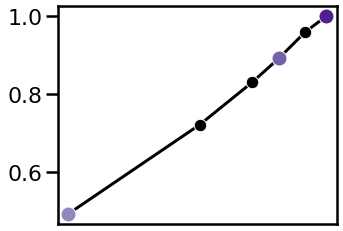

In [90]:
_, ax = plt.subplots(figsize=(5, 4))
ax.plot(plt_pows, plvs, color='black')
ax.plot(plt_pows, plvs, '.', ms=25, color='black', markeredgecolor='w')

for ind, color in zip(range(len(inds)), list(reversed(tcols))):
    ax.plot([osc_powers[inds[ind]]], [plvs[inds[ind]]], 
            '.', color=color, ms=30, markeredgecolor='w')

for xlabel_i in ax.get_xticklabels():
    xlabel_i.set_visible(False)
    xlabel_i.set_fontsize(0.0)
for tic in ax.xaxis.get_major_ticks():
    tic.tick1line.set_visible(False)
    
ax.set_xlim(0.52, -0.01)  # decreasing time

plt.savefig('figures/07-plvs_snrs.pdf', bbox_inches='tight')

In [56]:
plvs

[1.0,
 0.9592661498690245,
 0.8917501760874053,
 0.8308857326265221,
 0.7215099872979017,
 0.49195037063295655]

In [57]:
osc_powers

[0.01, 0.05, 0.1, 0.15, 0.25, 0.5]

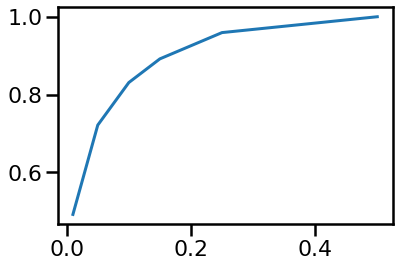

In [58]:
plt.plot(list(reversed(osc_powers)),
         plvs)
         #list(reversed(plvs)))